# Diffusion model - Forward process
Joel Clerc & Frédéric Charbonnier

Import libraries

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

Add noice, markov chain

$\beta_{t}$= linear schedule increasing from : 1e-4 to 2e-2  
$\alpha_{t}=1-\beta_{t}$  
$\epsilon = \mathcal{N}(0;I)$  

$q(x_{t}|x_{t-1})=\mathcal{N}(x_{t};\sqrt{\alpha_{t}}x_{t-1},\beta_{t}I) \\q(x_{1:T}|x_{0})=\prod_{t=1}^{T}q(x_{t}|x_{t-1})$

$\mathcal{N}(x_{t};\sqrt{\alpha_{t}}x_{t-1},\beta_{t}I) = \sqrt{\alpha_{t}}x_{t-1} * \sqrt{\beta_{t}} * \epsilon$



In [9]:
timesteps = 300
beta_min = 1e-4
beta_max = 2e-2
#TODO: Try others repartitions
betas = torch.linspace(beta_min, beta_max, steps=timesteps)
betas_sqrt = torch.sqrt(betas)
alphas = 1 - betas
alphas_sqrt = torch.sqrt(alphas)
alphas_bar = torch.cumprod(alphas,0)
alphas_bar_sqrt = torch.sqrt(alphas_bar)

def add_noise_stage(x,t) :
    mean = alphas_sqrt[t]*x
    std = betas_sqrt[t]
    x = mean + std*torch.randn_like(x)
    return x

Test with images

Load and visualize MNISTFashion Dataset

In [11]:
# Transform to Tensor and normalize value between 0 and 1
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=0.5,
                                                   std=0.5),
                             ])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Adding noise

torch.float32


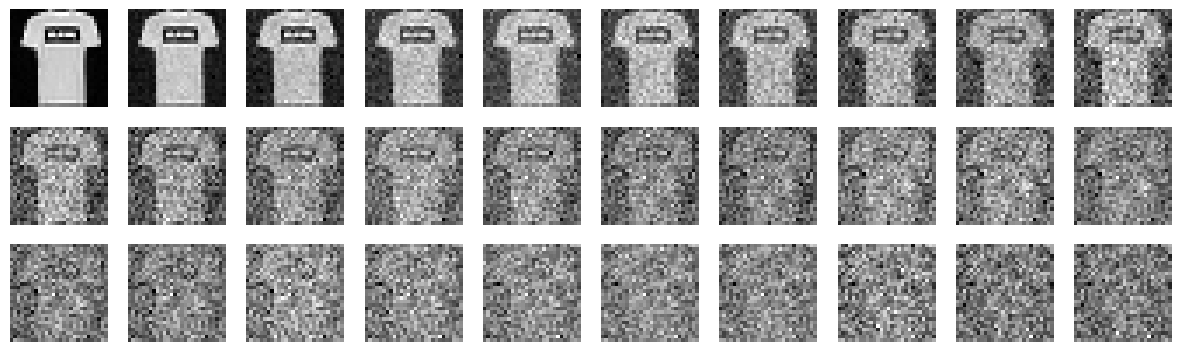

In [13]:
img, label = training_data[1]
x_init = img

figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
i = 0
x = x_init
print(x_init.dtype)
for t in range(1, timesteps):
    x = add_noise_stage(x,t)
    if (t == 1 or t % 10 == 0):
        i+=1
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap="gray")

Implemente parametrize trick.

$x_{t}=\sqrt{\alpha_{t}}x_{t-1}+\sqrt{1-\alpha_{t}} \epsilon_{t-1}\\=\sqrt{\alpha_{t}\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_{t}\alpha_{t-1}} \bar{\epsilon}_{t-2}\\=\text{...}\\=\sqrt{\bar{\alpha}_{t}}x_{0}+\sqrt{1-\bar{\alpha}_{t}}\epsilon \\\alpha_{t}=1-\beta_{t}, \bar{\alpha}_{t}=\prod_{t=1}^{T}\alpha_{t}$

In [25]:
def add_noise_directly(x_init,t) :
    mean = alphas_bar_sqrt[t]*x_init
    std = torch.sqrt(1-alphas_bar[t])
    x = mean + std*torch.randn_like(x_init)
    return x

Test directly

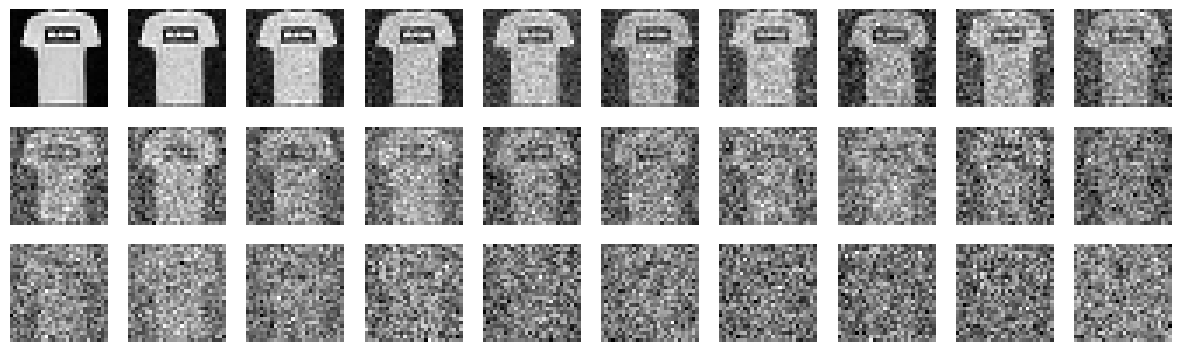

In [26]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
i = 0
for t in range(1, timesteps):
    if (t == 1 or t % 10 == 0):
        x = add_noise_directly(x_init,t)
        i+=1
        figure.add_subplot(rows, cols, i)
        #plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap="gray")

x_noised = x

Implemente calculate posterior $q(x_{t-1}|x_{t},x_{0})$

In [18]:
def reverse_step(x_init, x, t) :
    mean = alphas_bar_sqrt[t-1]*betas[t]/(1-alphas_bar[t])*x_init + alphas_sqrt[t]*(1-alphas_bar[t-1])/(1-alphas_bar[t])*x
    std = torch.sqrt((1-alphas_bar[t-1])/((1-alphas_bar[t]))*betas[t])
    return mean + std*torch.randn_like(x_init)

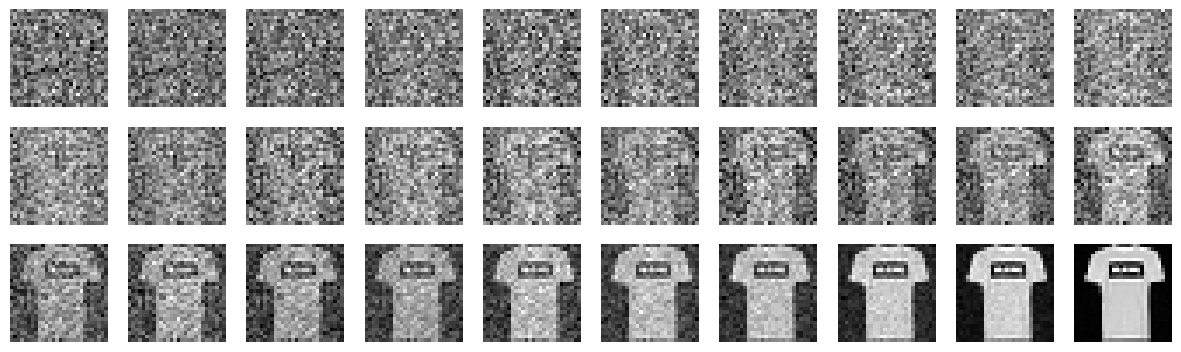

In [19]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10

#x = torch.randn_like(x_init)
x = x_noised
i = 0
for t in reversed(range(1, timesteps)):
    x = reverse_step(x_init, x, t)
    if (t == 1 or t % 10 == 0):
        i+=1
        figure.add_subplot(rows, cols, i)
        #plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap="gray")